In [1]:
import os

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import configparser


models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])


models_label = np.array([
                         'MRMv6.1',
                         'ESRA',
                         'Heliosat-1',
                         'Solis simple',
                         'CEM',
                         'MMAC',
                         'METSTAT',
 
                        ])

models_aodwvl = np.array([
                           550,
                           550,
                           550,
                           700,
                           0,
                           0,
                           0,
                          ])

### load dataset
# This dataset is produced with make_dataset_AOD_CSM_TCARS.py
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

fname_CAMS_AOD = os.path.join(pf,"TCARS_CSF_AOD_2015.nc")
dsAOD = xr.open_dataset(fname_CAMS_AOD)

In [2]:
def calc_AE(t1,t2,l1,l2):
    """ calculate Angstrom exponent from aods (t1,t2)
        at two different wavelengths (l1,l2)
    """
    return -np.log(t1/t2)/np.log(l1/l2)
def calc_AOD(l1,t2,l2,ae):
    return t2*(l1/l2)**(-ae)

In [3]:
AODvgl

<xarray.Dataset>
Dimensions:  (day: 238, model: 7, station: 25)
Coordinates:
  * day      (day) datetime64[ns] 2015-01-05 2015-01-06 ... 2015-12-31
  * station  (station) object 'AK' 'BG' 'BN' 'CH' 'DN' ... 'SY' 'TR' 'WN' 'WZ'
  * model    (model) object 'MRM61' 'MMAC' ... 'METSTAT' 'SOLISsimple'
Data variables:
    AOD0     (day, station, model) float64 nan nan nan nan ... nan nan nan nan
    AOD550   (day, station, model) float64 nan nan nan nan ... nan nan nan nan
    AOD700   (day, station, model) float64 nan nan nan nan ... nan nan nan nan
    CAOD     (day, station, model) float64 nan nan nan nan ... nan nan nan nan

## Make Table 08
Compare clear sky fittet AOD from the CSM to T-CARS AOD

In [5]:
def get_metrics(O,P):
    #ensure no nans in data
    idx = ~np.isnan(O)*~np.isinf(O)
    idx*= ~np.isnan(P)*~np.isinf(P)
    O = O[idx]
    P = P[idx]
    # precalculation
    N = len(O)
    N1 = 1./float(N)
    N2 = 1./(float(N)+1.)
    DELTA = P-O
    SUM = P+O
    # MBE
    MBE = N1 * np.sum(DELTA)
    # RMSE
    RMSE = np.sqrt(N2*np.sum(DELTA**2))
    # R
    ccoef = np.corrcoef(P,O)
    ccoef = ccoef[0][1]
    return MBE,RMSE,ccoef

AODvgl=dsAOD.copy()
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


## make Table
print("\\multicolumn{5}{|c|}{daily average AOD at 550\\,\\unit{nm}}}") 
print("\\middlehline")
# for wvl in [0,550,700]:
#     idx = models_aodwvl==wvl
    

#     for i,model in enumerate(zip(models[idx],models_label[idx])):
for m,model in enumerate(zip(models,models_label)):
    wvl = models_aodwvl[m]
    CAODs=[]
    model,mlabel=model

    AOD = AODvgl.mean(dim=['station'],skipna=True).sel(model=model)
    if wvl == 0: 
        AOD.CAOD.values =(AOD.CAOD * (AOD.AOD550 / AOD.AOD0)).values
    if wvl == 700:
        AE = calc_AE(AOD.AOD550,AOD.AOD700,550,700)
        AOD.CAOD.values = calc_AOD(550.,AOD.CAOD.values,700,AE.values)#(AOD.CAOD * (AOD.AOD550 / AOD.AOD700)).values
    AODseas = AOD.groupby('day.season').mean(skipna=True)
    for seas in ['DJF','MAM','JJA','SON']:
        CAODs.append(AODseas.CAOD.sel(season=seas).values)
    CAODs.append(AOD.CAOD.mean(dim='day',skipna=True).values)
    EARE = AOD[f'AOD550'].values
    DARE = AOD.CAOD.values
    mbe,rmse,corr = get_metrics(EARE,DARE)   

    print(f"{mlabel:12s}  & {CAODs[4]:6.2f} & {mbe:6.2f} & {rmse:6.2f} & {corr:6.2f} \\\\")

        

print("\\bottomhline")


\multicolumn{5}{|c|}{daily average AOD at 550\,\unit{nm}}}
\middlehline
MRMv6.1       &   0.10 &  -0.04 &   0.08 &   0.52 \\
ESRA          &   0.12 &  -0.01 &   0.06 &   0.68 \\
Heliosat-1    &   0.07 &  -0.05 &   0.08 &   0.62 \\
Solis simple  &   0.10 &  -0.03 &   0.08 &   0.48 \\
CEM           &   0.15 &   0.01 &   0.07 &   0.52 \\
MMAC          &   0.39 &   0.25 &   0.31 &   0.70 \\
METSTAT       &   0.13 &  -0.01 &   0.07 &   0.70 \\
\bottomhline


In [2]:
def get_metrics(O,P):
    #ensure no nans in data
    idx = ~np.isnan(O)*~np.isinf(O)
    idx*= ~np.isnan(P)*~np.isinf(P)
    O = O[idx]
    P = P[idx]
    # precalculation
    N = len(O)
    N1 = 1./float(N)
    N2 = 1./(float(N)+1.)
    DELTA = P-O
    SUM = P+O
    # MBE
    MBE = N1 * np.sum(DELTA)
    # RMSE
    RMSE = np.sqrt(N2*np.sum(DELTA**2))
    # R
    ccoef = np.corrcoef(P,O)
    ccoef = ccoef[0][1]
    return MBE,RMSE,ccoef

AODvgl=dsAOD.copy()
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


## make Table
for wvl in [0,550,700]:
    idx = models_aodwvl==wvl
    print("\\multirow{%d}{*}{\\rotatebox[origin=c]{90}{%d\\,\\unit{nm}}}"%(1+np.count_nonzero(idx),wvl)) 

    for i,model in enumerate(zip(models[idx],models_label[idx])):
        CAODs=[]
        model,mlabel=model
        
        AOD = AODvgl.mean(dim=['station'],skipna=True).sel(model=model)
        AODseas = AOD.groupby('day.season').mean(skipna=True)
        for seas in ['DJF','MAM','JJA','SON']:
            CAODs.append(AODseas.CAOD.sel(season=seas).values)
        CAODs.append(AOD.CAOD.mean(dim='day',skipna=True).values)
        EARE = AOD[f'AOD{wvl:d}'].values
        DARE = AOD.CAOD.values
        mbe,rmse,corr = get_metrics(EARE,DARE)   

        print(f"& {mlabel:12s}  & {CAODs[0]:6.2f} & {CAODs[1]:6.2f} & {CAODs[2]:6.2f}  & {CAODs[3]:6.2f}  & {CAODs[4]:6.2f} & {mbe:6.2f} & {rmse:6.2f} & {corr:6.2f} \\\\")

    CAODs=[]
    AOD = AODvgl.sel(model=models[idx]).mean(dim=['station','model'],skipna=True)
    AODseas = AOD.groupby('day.season').mean(skipna=True)
    for seas in ['DJF','MAM','JJA','SON']:
        CAODs.append(AODseas[f"AOD{wvl}"].sel(season=seas).values)
    CAODs.append(AOD[f"AOD{wvl}"].mean(dim='day',skipna=True).values)

    print("& T-CARS "+f"  & {CAODs[0]:6.2f} & {CAODs[1]:6.2f} & {CAODs[2]:6.2f}  & {CAODs[3]:6.2f}  & {CAODs[4]:6.2f} &-&-&-\\\\")
        
    print("\\middlehline")





\multirow{4}{*}{\rotatebox[origin=c]{90}{0\,\unit{nm}}}
& MMAC          &   0.11 &   0.15 &   0.19  &   0.11  &   0.15 &   0.10 &   0.12 &   0.76 \\
& CEM           &   0.05 &   0.06 &   0.07  &   0.05  &   0.06 &   0.00 &   0.02 &   0.77 \\
& METSTAT       &   0.03 &   0.04 &   0.07  &   0.04  &   0.05 &  -0.00 &   0.02 &   0.77 \\
& T-CARS   &   0.03 &   0.05 &   0.08  &   0.03  &   0.06 &-&-&-\\
\middlehline
\multirow{4}{*}{\rotatebox[origin=c]{90}{550\,\unit{nm}}}
& MRMv6.1       &   0.10 &   0.10 &   0.11  &   0.09  &   0.10 &  -0.04 &   0.08 &   0.52 \\
& Heliosat-1    &   0.04 &   0.07 &   0.11  &   0.05  &   0.07 &  -0.05 &   0.08 &   0.62 \\
& ESRA          &   0.08 &   0.12 &   0.16  &   0.10  &   0.12 &  -0.01 &   0.06 &   0.68 \\
& T-CARS   &   0.06 &   0.14 &   0.20  &   0.09  &   0.13 &-&-&-\\
\middlehline
\multirow{2}{*}{\rotatebox[origin=c]{90}{700\,\unit{nm}}}
& Solis simple  &   0.07 &   0.08 &   0.07  &   0.07  &   0.07 &  -0.02 &   0.05 &   0.45 \\
& T-CARS   &   0.

In [45]:
def get_metrics(O,P):
    #ensure no nans in data
    idx = ~np.isnan(O)*~np.isinf(O)
    idx*= ~np.isnan(P)*~np.isinf(P)
    O = O[idx]
    P = P[idx]
    # precalculation
    N = len(O)
    N1 = 1./float(N)
    N2 = 1./(float(N)+1.)
    DELTA = P-O
    SUM = P+O
    # MBE
    MBE = N1 * np.sum(DELTA)
    # RMSE
    RMSE = np.sqrt(N2*np.sum(DELTA**2))
    # R
    ccoef = np.corrcoef(P,O)
    ccoef = ccoef[0][1]
    return MBE,RMSE,ccoef

AODvgl=dsAOD.copy()
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


## make Table
print("\\multirow{8}{*}{\\rotatebox[origin=c]{90}{550\\,\\unit{nm}}}") 
# for wvl in [0,550,700]:
#     idx = models_aodwvl==wvl
    

#     for i,model in enumerate(zip(models[idx],models_label[idx])):
for m,model in enumerate(zip(models,models_label)):
    wvl = models_aodwvl[m]
    CAODs=[]
    model,mlabel=model

    AOD = AODvgl.mean(dim=['station'],skipna=True).sel(model=model)
    if wvl == 0: 
        AOD.CAOD.values =(AOD.CAOD * (AOD.AOD550 / AOD.AOD0)).values
    if wvl == 700:
        AE = calc_AE(AOD.AOD550,AOD.AOD700,550,700)
        AOD.CAOD.values = calc_AOD(550.,AOD.CAOD.values,700,AE.values)#(AOD.CAOD * (AOD.AOD550 / AOD.AOD700)).values
    AODseas = AOD.groupby('day.season').mean(skipna=True)
    for seas in ['DJF','MAM','JJA','SON']:
        CAODs.append(AODseas.CAOD.sel(season=seas).values)
    CAODs.append(AOD.CAOD.mean(dim='day',skipna=True).values)
    EARE = AOD[f'AOD550'].values
    DARE = AOD.CAOD.values
    mbe,rmse,corr = get_metrics(EARE,DARE)   

    print(f"& {mlabel:12s}  & {CAODs[0]:6.2f} & {CAODs[1]:6.2f} & {CAODs[2]:6.2f}  & {CAODs[3]:6.2f}  & {CAODs[4]:6.2f} & {mbe:6.2f} & {rmse:6.2f} & {corr:6.2f} \\\\")

        
CAODs=[]
AOD = AODvgl.sel(model=models[idx]).mean(dim=['station','model'],skipna=True)
AODseas = AOD.groupby('day.season').mean(skipna=True)
for seas in ['DJF','MAM','JJA','SON']:
    CAODs.append(AODseas[f"AOD550"].sel(season=seas).values)
CAODs.append(AOD[f"AOD550"].mean(dim='day',skipna=True).values)

print("& T-CARS "+f"  & {CAODs[0]:6.2f} & {CAODs[1]:6.2f} & {CAODs[2]:6.2f}  & {CAODs[3]:6.2f}  & {CAODs[4]:6.2f} &-&-&-\\\\")

print("\\middlehline")





\multirow{8}{*}{\rotatebox[origin=c]{90}{550\,\unit{nm}}}
& MRMv6.1       &   0.10 &   0.10 &   0.11  &   0.09  &   0.10 &  -0.04 &   0.08 &   0.52 \\
& ESRA          &   0.08 &   0.12 &   0.16  &   0.10  &   0.12 &  -0.01 &   0.06 &   0.68 \\
& Heliosat-1    &   0.04 &   0.07 &   0.11  &   0.05  &   0.07 &  -0.05 &   0.08 &   0.62 \\
& Solis simple  &   0.09 &   0.11 &   0.10  &   0.09  &   0.10 &  -0.03 &   0.08 &   0.48 \\
& CEM           &   0.12 &   0.14 &   0.16  &   0.14  &   0.15 &   0.01 &   0.07 &   0.52 \\
& MMAC          &   0.27 &   0.37 &   0.50  &   0.29  &   0.39 &   0.25 &   0.31 &   0.70 \\
& METSTAT       &   0.10 &   0.10 &   0.18  &   0.10  &   0.13 &  -0.01 &   0.07 &   0.70 \\
& T-CARS   &   0.06 &   0.14 &   0.20  &   0.09  &   0.13 &-&-&-\\
\middlehline


## Make Figure 13
Annual overview of AOD from T-CARS and CSM

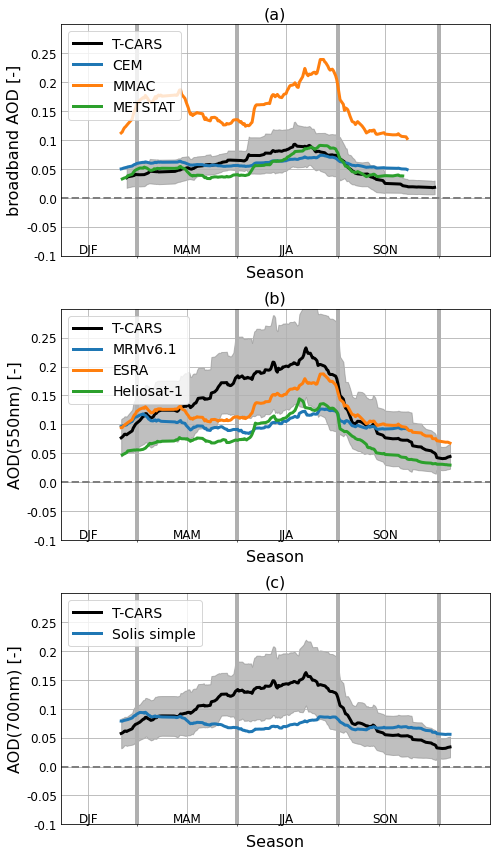

In [42]:

AODvgl=dsAOD.copy()

AODvgl = AODvgl.assign_coords({'dayofyear':('day',AODvgl.day.dt.dayofyear)})
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


fig,axs = plt.subplots(3,1,figsize=(7,12))

AOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).mean(skipna=True)
dAOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).std(skipna=True)

axs[0].set_title('(a)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD0),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD0),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[0].fill_between(pAOD.dayofyear,
                    pAOD.AOD0-pdAOD.AOD0,
                    pAOD.AOD0+pdAOD.AOD0,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[0].plot(pAOD.dayofyear.values,pAOD.AOD0,
            color='k',linewidth=3,label='T-CARS')

axs[1].set_title('(b)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD550),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD550),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[1].fill_between(pAOD.dayofyear,
                    pAOD.AOD550-pdAOD.AOD550,
                    pAOD.AOD550+pdAOD.AOD550,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[1].plot(pAOD.dayofyear.values,pAOD.AOD550,
            color='k',linewidth=3,label='T-CARS')

axs[2].set_title('(c)',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD700),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD700),drop=True).rolling(day=30,center=True).std(skipna=True)
axs[2].fill_between(pAOD.dayofyear,
                    pAOD.AOD700-pdAOD.AOD700,
                    pAOD.AOD700+pdAOD.AOD700,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs[2].plot(pAOD.dayofyear.values,pAOD.AOD700,
            color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    wvl = models_aodwvl[m]
    if wvl == 0:
        i=0
    elif wvl == 550:
        i=1
    else:
        i=2
        
    AOD = AODvgl.sel(model=model).mean(dim=['station'],skipna=True)#.rolling(day=30,center=True).mean()
    pAOD = AOD.where(~np.isnan(AOD.CAOD),drop=True).rolling(day=30,center=True).mean(skipna=True)
    axs[i].plot(pAOD.dayofyear,
                pAOD.CAOD,
                linestyle='-',linewidth=3,label=mlabel)
    
  
for i,ax in enumerate(axs):
    ax.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))
    ax.legend(loc=2,fontsize=14)
    ax.set_xlim([-10,380])
    ax.set_ylim([-0.1,0.3])
    # config axis labels
    ax.set_xticks(np.linspace(15,285,4))
    ax.set_yticks(np.arange(-0.1,0.3,0.05)+0.0000001)
    ax.set_xticklabels(['DJF','MAM','JJA','SON'],fontsize=14)#,fontweight='bold')
    ax.set_yticklabels(np.round(np.arange(-0.1,0.3,0.05),2),fontsize=14)
    ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
    ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
    # config for gridlines
    ax.set_xticks(np.linspace(59,334,4),minor=True)
    ax.set_yticks(np.arange(-0.1,0.3,0.05),minor = True)
    ax.grid(which='minor')
    ax.tick_params('x',which='minor',grid_linewidth=4)
    ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
    ax.set_xlabel('Season',fontsize=16)#,fontweight='bold')
    ax.grid(True)
    if i==0:
        ax.set_ylabel("broadband AOD [-]",fontsize=16)#,fontweight='bold')
    elif i==1:
        ax.set_ylabel("AOD(550nm) [-]",fontsize=16)#,fontweight='bold')
    else:
        ax.set_ylabel("AOD(700nm) [-]",fontsize=16)#,fontweight='bold')
    

plt.tight_layout()
plt.savefig('figures/Fig13.pdf',dpi=300,bbox_inches='tight')

# Fig 13 , scaled to 550nm
the same figure, but AOD700 and broadband AOD from clear sky fit are scaled to 550nm

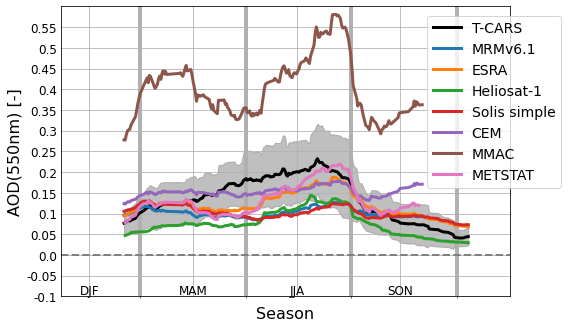

In [41]:



AODvgl=dsAOD.copy()

AODvgl = AODvgl.assign_coords({'dayofyear':('day',AODvgl.day.dt.dayofyear)})
AODvgl = AODvgl.where(AODvgl.CAOD>0,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD<0.7,drop=True)
AODvgl = AODvgl.where(AODvgl.CAOD.round(3)!=0.3,drop=True)


fig,axs = plt.subplots(1,1,figsize=(8,4.8))

AOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).mean(skipna=True)
dAOD = AODvgl.mean(dim=['station','model'],skipna=True)#.rolling(day=30,center=True).std(skipna=True)



axs.set_title('',fontsize=16)
pAOD = AOD.where(~np.isnan(AOD.AOD550),drop=True).rolling(day=30,center=True).mean(skipna=True)
pdAOD = dAOD.where(~np.isnan(dAOD.AOD550),drop=True).rolling(day=30,center=True).std(skipna=True)
axs.fill_between(pAOD.dayofyear,
                    pAOD.AOD550-pdAOD.AOD550,
                    pAOD.AOD550+pdAOD.AOD550,
                    color=(0.5,0.5,0.5),alpha=0.5)
axs.plot(pAOD.dayofyear.values,pAOD.AOD550,
            color='k',linewidth=3,label='T-CARS')


for m,model in enumerate(zip(models,models_label)):
    model,mlabel=model
    wvl = models_aodwvl[m]
        
    AOD = AODvgl.sel(model=model).mean(dim=['station'],skipna=True)#.rolling(day=30,center=True).mean()
    pAOD = AOD.where(~np.isnan(AOD.CAOD),drop=True).interpolate_na(dim='day').rolling(day=30,center=True).mean(skipna=True)
    if wvl == 0: 
        pAOD.CAOD.values =(pAOD.CAOD * (pAOD.AOD550 / pAOD.AOD0)).values
    if wvl == 700:
        AE = calc_AE(pAOD.AOD550,pAOD.AOD700,550,700)
        pAOD.CAOD.values = calc_AOD(550.,pAOD.CAOD.values,700,AE.values)
#         pAOD.CAOD.values =(pAOD.CAOD * (pAOD.AOD550 / pAOD.AOD700)).values    

    axs.plot(pAOD.dayofyear,
                pAOD.CAOD,
                linestyle='-',linewidth=3,label=mlabel)
    
  
for i,ax in enumerate([axs]):
    ax.axhline(0,linestyle='--',linewidth=2,color=(0.5,0.5,0.5))
#     ax.legend(loc=2,fontsize=14)
    ax.set_xlim([-10,380])
    ax.set_ylim([-0.05,0.6])
    # config axis labels
    ax.set_xticks(np.linspace(15,285,4))
    ax.set_yticks(np.arange(-0.1,0.6,0.05)+0.0000001)
    ax.set_xticklabels(['DJF','MAM','JJA','SON'],fontsize=14)#,fontweight='bold')
    ax.set_yticklabels(np.round(np.arange(-0.1,0.6,0.05),2),fontsize=14)
    ax.tick_params('x',color='',length=0,pad=-12,labelsize='large')
    ax.tick_params('y',color='',length=0,labelsize='large',labelleft=True,labelright=False)#pad=-25
    # config for gridlines
    ax.set_xticks(np.linspace(59,334,4),minor=True)
    ax.set_yticks(np.arange(-0.1,0.3,0.05),minor = True)
    ax.grid(which='minor')
    ax.tick_params('x',which='minor',grid_linewidth=4)
    ax.tick_params('y',which='minor',color='k',length=1,pad=-20)
    ax.set_xlabel('Season',fontsize=16)#,fontweight='bold')
    ax.grid(True)

    ax.set_ylabel("AOD(550nm) [-]",fontsize=16)#,fontweight='bold')
    plt.legend(fontsize=14,bbox_to_anchor=(0.8, 0.35))#bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
    

plt.tight_layout()
plt.savefig('figures/Fig13_550nm.pdf',dpi=300,bbox_inches='tight')